In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import ccf, grangercausalitytests, adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import warnings
warnings.filterwarnings("ignore")

In [ ]:
crypto_price_base_path = "/content/drive/MyDrive/CS526_DS_Group/Numeric Model/datasets/crypto prices/"
crypto_options = ["BTC", "ETH", "XRP", 'USDT']
def get_crypto_price_path(option, time_range="2022"):
    if option in crypto_options:
        if time_range == "all":
            return crypto_price_base_path + option + ".csv"
        else:
            return crypto_price_base_path + option + f"_{time_range}.csv"
    else:
        raise Exception("Invalid crypto options")

exogenous_data_path = "/content/drive/MyDrive/CS526_DS_Group/Numeric Model/datasets/combined_2022_data.csv"
crypto_price_path = get_crypto_price_path("BTC", time_range="2022")
data = pd.read_csv(exogenous_data_path, index_col='date', parse_dates=True)
price = pd.read_csv(crypto_price_path, index_col='date', parse_dates=True)

# Load Data
train_size = 0.8
train_data_days = int(365 * train_size)
btc_price = price['close']
btc_price_train, btc_price_test = btc_price[:train_data_days], btc_price[train_data_days:]
exogenous_data = data[['TEU-ENG', 'fng_value']]
exogenous_data_train, exogenous_data_test = exogenous_data[:train_data_days], exogenous_data[train_data_days:]

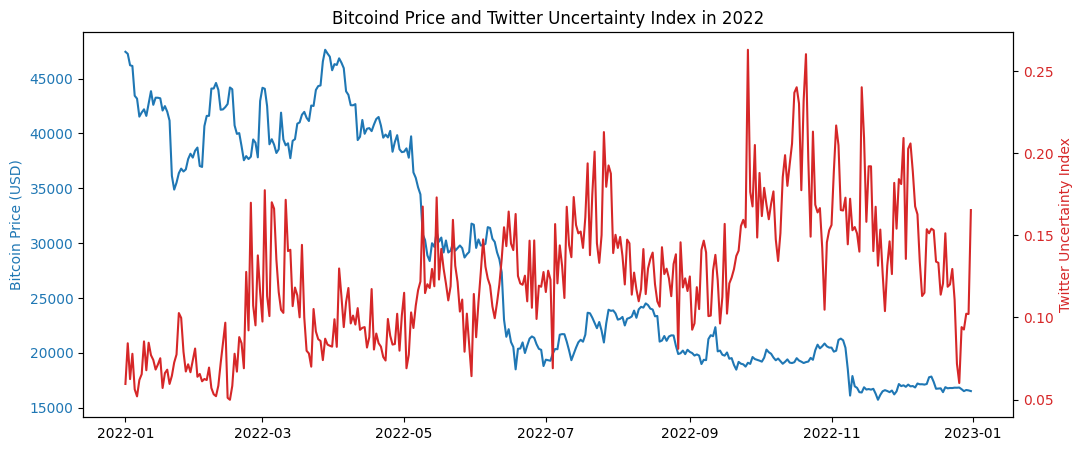

In [ ]:
# Plot price together with teu

# Create figure and axes
fig, ax1 = plt.subplots(figsize=(12, 5))
s1 = btc_price
s1.name = "Bitcoin Price"
s2 = data['TEU-ENG']
s2.name = "Twitter Uncertainty Index"

# Plot the first series
ax1.plot(s1.index, s1, color='tab:blue', label=s1.name)
ax1.set_ylabel("Bitcoin Price (USD)", color='tab:blue')

# Create a second y-axis sharing the same x-axis
ax2 = ax1.twinx()

# Plot the second series
ax2.plot(s2.index, s2, color='tab:red', label=s2.name)
ax2.set_ylabel(s2.name, color='tab:red')

# Optional enhancements
ax1.set_title("Bitcoind Price and Twitter Uncertainty Index in 2022")
ax1.tick_params(axis='y', labelcolor='tab:blue')
ax2.tick_params(axis='y', labelcolor='tab:red')

plt.show()


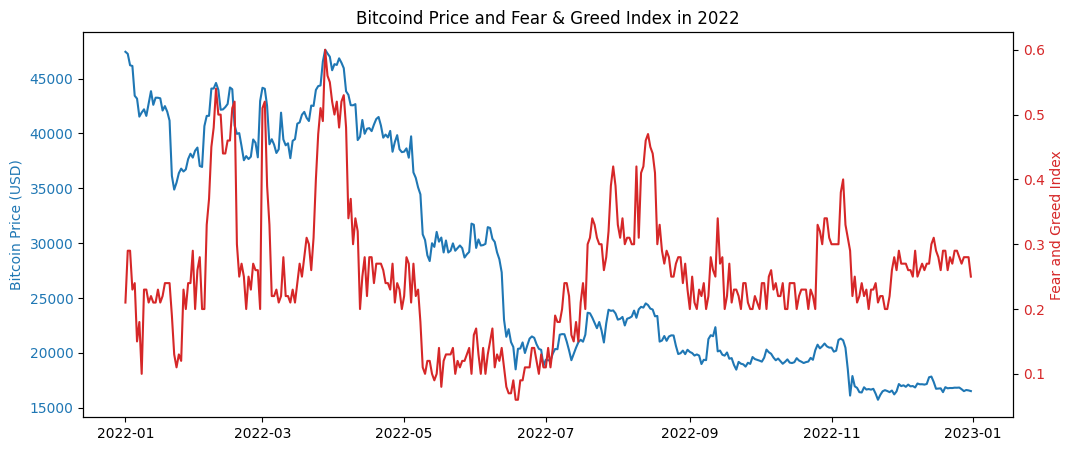

In [ ]:
# Plot price together with fng

# Create figure and axes
fig, ax1 = plt.subplots(figsize=(12, 5))
s1 = btc_price
s1.name = "Bitcoin Price"
s2 = data['fng_value']
s2.name = "Fear and Greed Index"

# Plot the first series
ax1.plot(s1.index, s1, color='tab:blue', label=s1.name)
ax1.set_ylabel("Bitcoin Price (USD)", color='tab:blue')

# Create a second y-axis sharing the same x-axis
ax2 = ax1.twinx()

# Plot the second series
ax2.plot(s2.index, s2, color='tab:red', label=s2.name)
ax2.set_ylabel(s2.name, color='tab:red')

# Optional enhancements
ax1.set_title("Bitcoind Price and Fear & Greed Index in 2022")
ax1.tick_params(axis='y', labelcolor='tab:blue')
ax2.tick_params(axis='y', labelcolor='tab:red')

plt.show()


In [ ]:
# heat map
teu = exogenous_data['TEU-ENG'].shift(1).dropna()
teu.name = "Twitter Uncertainty Index"
fng = exogenous_data['fng_value'].shift(1).dropna()
fng.name = "Fear and Greed Index"
btc_price = price['close'][1:]
btc_price.name = "price"
df = pd.concat([btc_price, teu, fng], axis=1)
df.corr()

,price,Twitter Uncertainty Index,Fear and Greed Index
price,1.000000,-0.647863,0.291772
Twitter Uncertainty Index,-0.647863,1.000000,-0.150345
Fear and Greed Index,0.291772,-0.150345,1.000000


In [ ]:
df_diff = df.diff().dropna()
df_diff.corr()

,price,Twitter Uncertainty Index,Fear and Greed Index
price,1.000000,0.014011,0.006731
Twitter Uncertainty Index,0.014011,1.000000,-0.069649
Fear and Greed Index,0.006731,-0.069649,1.000000


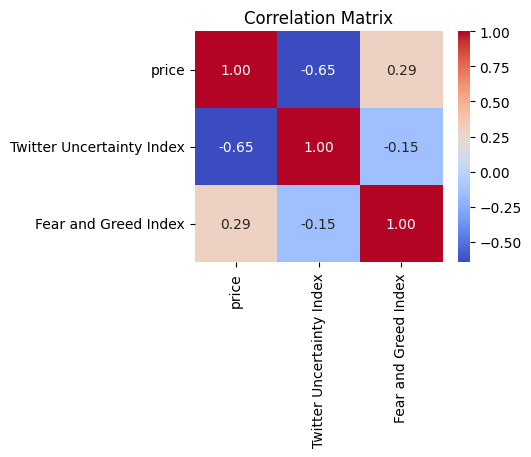

In [ ]:
plt.figure(figsize=(4, 3))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

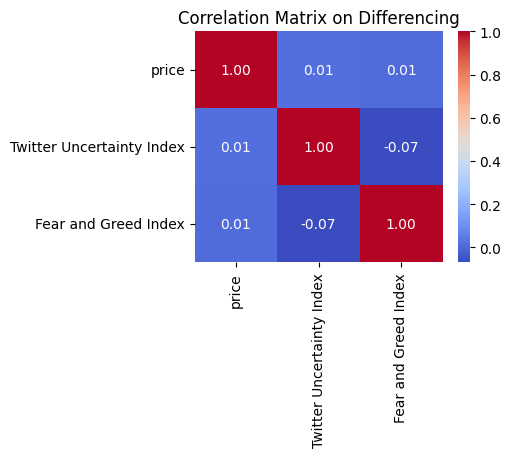

In [ ]:
plt.figure(figsize=(4, 3))
sns.heatmap(df_diff.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix on Differencing")
plt.show()

- The original -0.65 correlation was likely driven by a shared trend — for example, both series increasing over time (which can create a spurious correlation).
- Once you removed the trend (via differencing), that apparent link disappeared.
- So, the two series move in similar directions over time (both trending upward, say), but their short-term fluctuations aren't related.

check data is stationary or not:
ADF Statistic: -1.3470999264849886
p-value: 0.6073582602762828
data is non-stationary，differencing is required


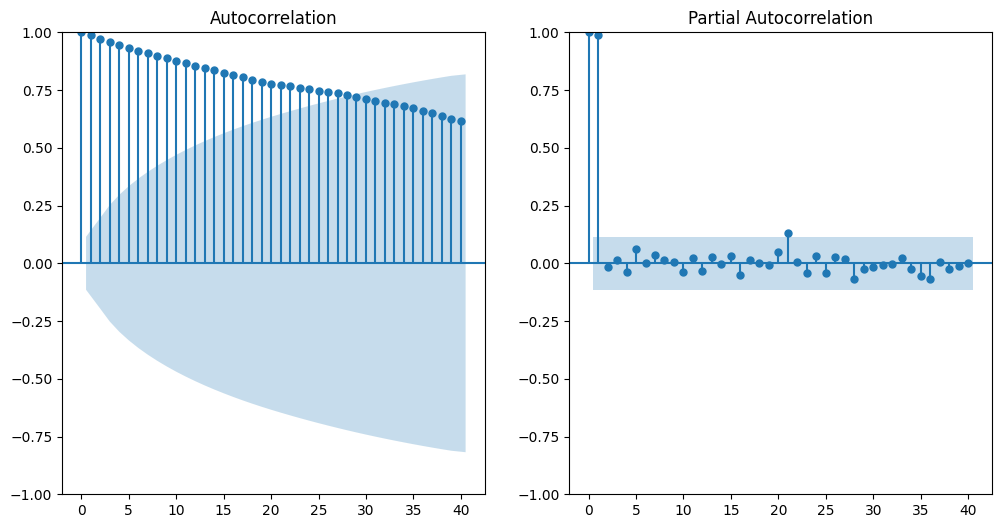

------------------------------------------------------------------------------------------------------------------------
check first-order difference data is stationary or not
ADF Statistic: -16.542379278202848
p-value: 1.9785091504472724e-29
data is stationary


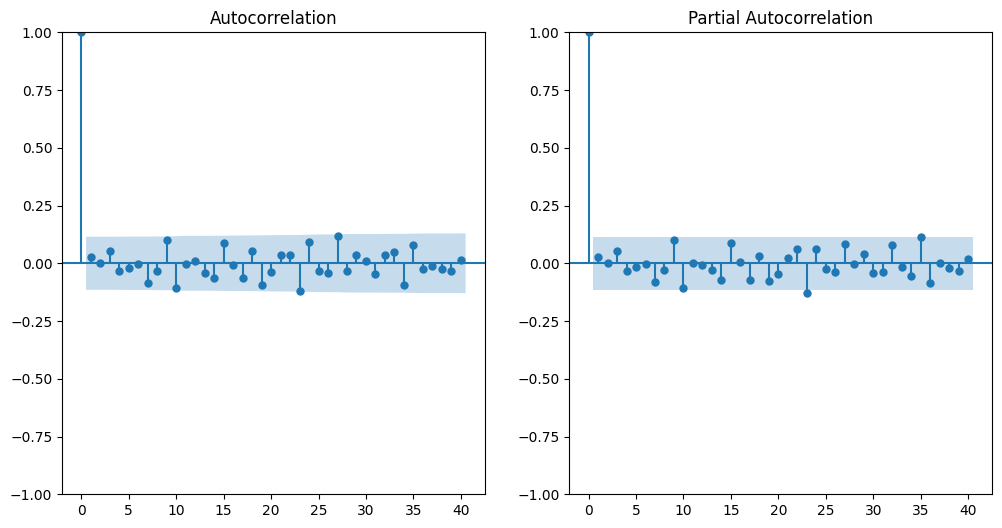

------------------------------------------------------------------------------------------------------------------------


In [ ]:
# ADF Test: check a time series data is stationary or not
def check_stationarity(series):
    result = adfuller(series)
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {result[1]}')
    if result[1] < 0.05:
        print("data is stationary")
    else:
        print("data is non-stationary，differencing is required")

def plot_acf_pacf(series):
    plt.figure(figsize=(12, 6))
    plt.subplot(121)
    plot_acf(series, lags=40, ax=plt.gca())  # ACF graph
    plt.subplot(122)
    plot_pacf(series, lags=40, ax=plt.gca())  # PACF graph
    plt.show()
    print("-" * 120) # separator

print("check data is stationary or not:")
check_stationarity(btc_price_train)
plot_acf_pacf(btc_price_train)

# check first-order difference data is stationary or not
btc_price_diff = btc_price_train.diff().dropna()
print("check first-order difference data is stationary or not")
check_stationarity(btc_price_diff)
plot_acf_pacf(btc_price_diff)

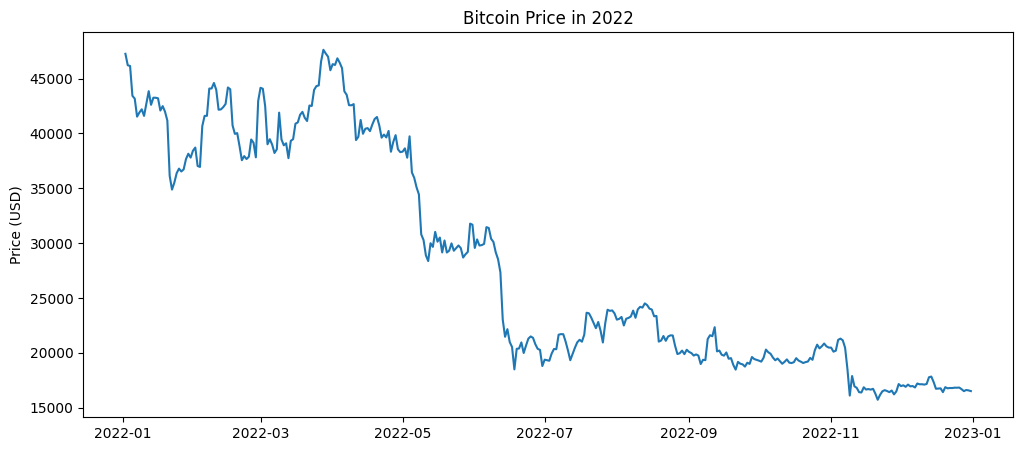

In [ ]:
plt.figure(figsize=(12, 5))
plt.plot(btc_price.index, btc_price)
plt.title("Bitcoin Price in 2022")
plt.ylabel('Price (USD)')
plt.show()

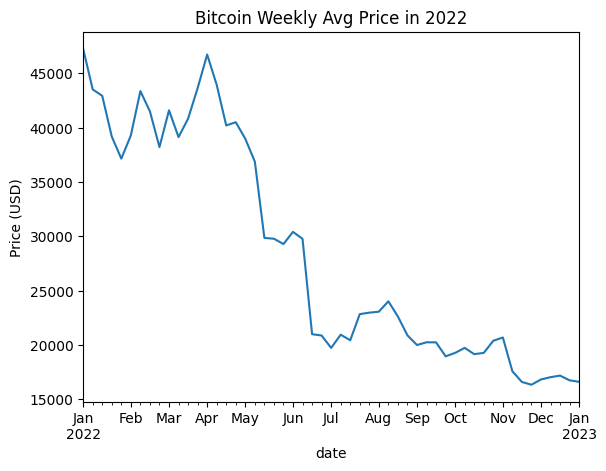

In [ ]:
btc_price.resample('W').mean().plot(title='Bitcoin Weekly Avg Price in 2022')
plt.ylabel('Price (USD)')
plt.show()

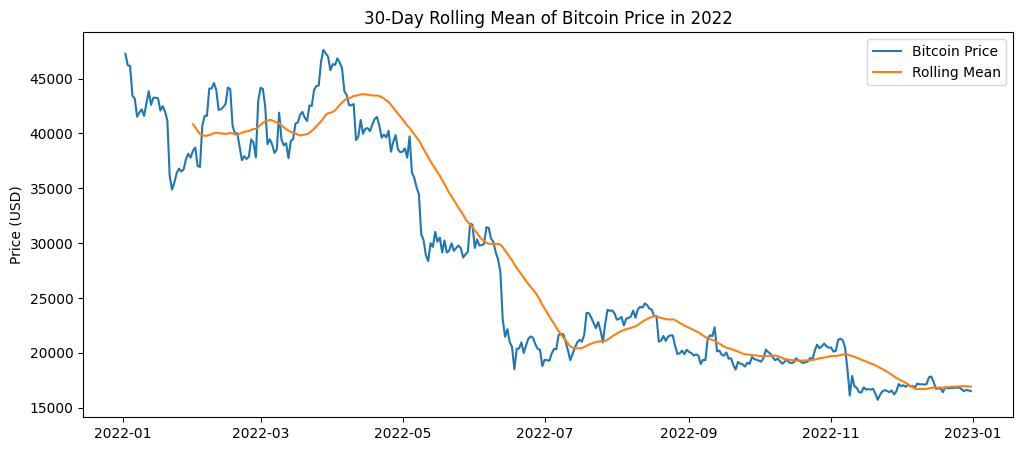

In [ ]:
rolling_mean = btc_price.rolling(window=30).mean()
plt.figure(figsize=(12, 5))
plt.plot(btc_price.index, btc_price, label='Bitcoin Price')
plt.plot(rolling_mean.index, rolling_mean, label='Rolling Mean')
plt.title('30-Day Rolling Mean of Bitcoin Price in 2022')
plt.legend()
plt.ylabel("Price (USD)")
plt.show()

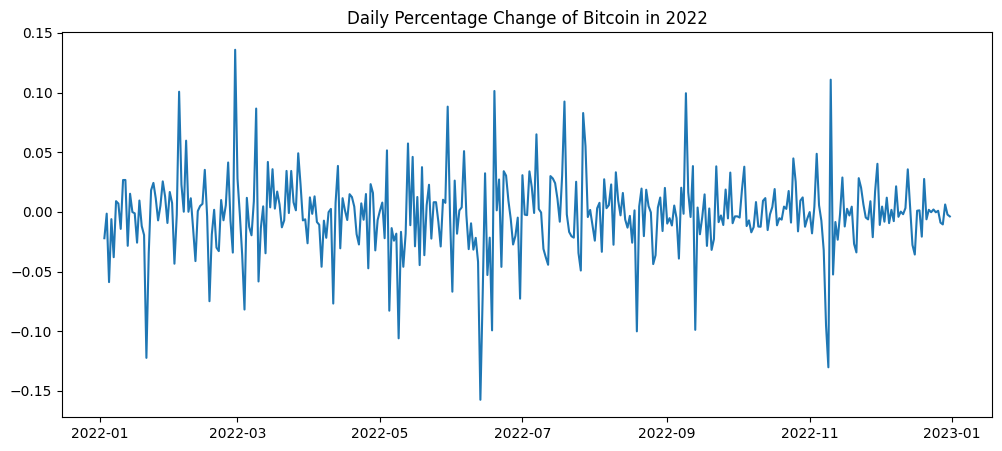

In [ ]:
pct_change = btc_price.pct_change()
plt.figure(figsize=(12, 5))
plt.plot(pct_change.index, pct_change)
plt.title("Daily Percentage Change of Bitcoin in 2022")
plt.show()

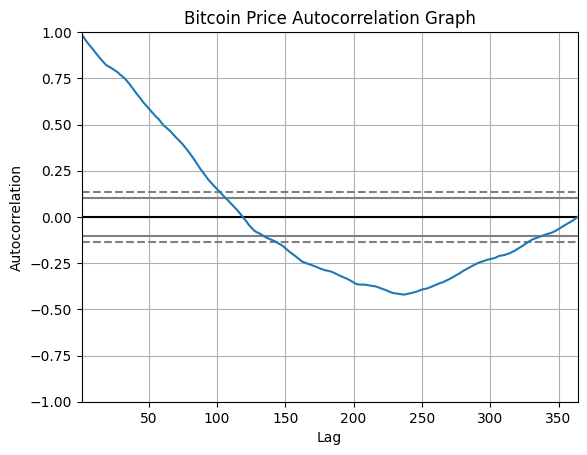

In [ ]:
from pandas.plotting import autocorrelation_plot

autocorrelation_plot(btc_price)
plt.title("Bitcoin Price Autocorrelation Graph")
plt.show()